## 1. Import modules & csv files

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


applications = pd.read_csv("application_record.csv")
credit_hist = pd.read_csv("credit_record.csv")
print(f"Total number of entries: {applications.shape[0]}")
applications.head()

Total number of entries: 438557


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


## 2. Pre-processing of application records
Pre-processing done:
- Remove duplicates
- Remove outliers

In [66]:
#Remove duplicate IDs, keep first occurence of that ID
applications.drop_duplicates("ID", keep="first", inplace=True)

In [35]:
# Credit to: https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-a-pandas-dataframe
def remove_outlier(df_in, col_name):
    '''
    Remove outliers in a given column from a Pandas dataframe
    Uses +- 1.5 IQR as criteria
    '''
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [69]:
# Remove income outliers. May be useful for data viz.
# Can consider plotting a graph with outliers included and another grpah with outliers excluded
apps = remove_outlier(applications, "AMT_INCOME_TOTAL")

apps.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
5,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
6,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


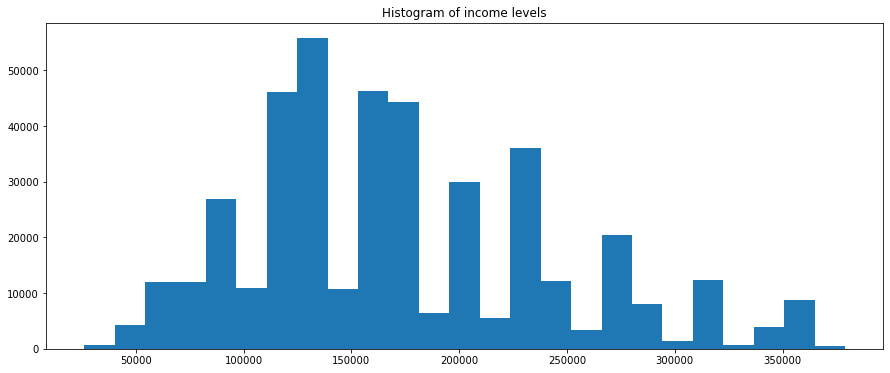

In [70]:
plt.figure(figsize=(15,6))
# plt.hist(applications["AMT_INCOME_TOTAL"], 150)
plt.hist(apps["AMT_INCOME_TOTAL"], 25)
plt.ticklabel_format(style="plain")
plt.title("Histogram of income levels")

plt.show()

Defining income groups (may be useful for data viz?)

In [71]:
# Represents interval between each income group 
# e.g. 50000 means the groups are: <50k, 50k-100k, 100k-150k and so on

INCOME_GROUP_INTERVAL = 50000


# Define income groups. Numbers represent upper limit 
# e.g. 150000 means < 150000 and > 100000 (the previous number in the list)
income_groups = []
income_group_cutoff = INCOME_GROUP_INTERVAL
while income_group_cutoff < apps["AMT_INCOME_TOTAL"].max():
    income_groups.append(income_group_cutoff)
    income_group_cutoff += INCOME_GROUP_INTERVAL
income_groups.append(income_group_cutoff)

print(income_groups)

[50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000]


In [40]:
# app_income_groups = []
# for income in income_groups:
#     income_lower = income - INCOME_GROUP_INTERVAL
#     app_income_groups.append(applications.loc[(applications["AMT_INCOME_TOTAL"]<=income) & 
#                                                   (applications["AMT_INCOME_TOTAL"]>income_lower),
#                                                   ["ID", "AMT_INCOME_TOTAL"]])
#     print(f"Appended {income_lower} to {income}")

Appended 0 to 50000
Appended 50000 to 100000
Appended 100000 to 150000
Appended 150000 to 200000
Appended 200000 to 250000
Appended 250000 to 300000
Appended 300000 to 350000
Appended 350000 to 400000


## 3. Pre-processing of credit histories
Pre-processing done:
- Assign STATUS 1 to all clients with any instance of overdue in their history, and STATUS 0 to the rest (all paid-off or no loan)
- Group entries by ID. Each ID now only has 1 entry instead of multiple entries

In [48]:
#Create a deep copy of credit_hist to avoid affecting original dataframe
credit_hist_grouped = credit_hist.copy(deep=True)

# Replace STATUS "X" and "C" with "0" i.e. paid off loan and no loan are considered good behaviour (STATUS 0)
credit_hist_grouped["STATUS"].replace(["X", "C"], "0", inplace=True)

#Change STATUS froms tring to int
credit_hist_grouped["STATUS"] = credit_hist_grouped["STATUS"].astype(int)

#Replace STATUS "0", "1" ... "5" with "1" i.e. any overdue behaviour, no matter how long, is considered bad behaviour (STATUS 1)
credit_hist_grouped.loc[credit_hist_grouped["STATUS"]>=1, "STATUS"] = 1

In [56]:
#Visualize some of the entries
credit_hist_grouped.iloc[215:250,:]

,ID,STATUS,MONTHS_AGO
215,5001719,0,34
216,5001719,0,35
217,5001719,0,36
218,5001719,0,37
219,5001719,0,38
220,5001719,0,39
221,5001719,0,40
222,5001719,0,41
223,5001719,0,42
224,5001720,1,0


In [55]:
# Record how many months ago was that particular record for, in terms of positive numbers (e.g. 1 month ago, 2 months ago)
credit_hist_grouped["MONTHS_AGO"] = credit_hist_grouped["MONTHS_BALANCE"] * -1

# Remove MONTHS_BALANCE column
credit_hist_grouped.drop(["MONTHS_BALANCE"], axis=1, inplace=True)

In [57]:
# Collapse credit_hist, by grouping all the entries with the same ID together. 
# For STATUS and MONTHS_AGO we take the max value amongst all entries with the same ID. So a person
# with even 1 overdue in all their credit history is considered "bad" (STATUS 1), while another
# person with all paid-off or no-loan is considered "good" (STATUS 0).

credit_hist_agg = credit_hist_grouped.groupby(["ID"]).agg(max)

credit_hist_agg.head(10)

,STATUS,MONTHS_AGO
ID,,
5001711,0,3
5001712,0,18
5001713,0,21
5001714,0,14
5001715,0,59
5001717,0,21
5001718,1,38
5001719,0,42
5001720,1,35


In [60]:
# CREDIT_HIST_LEN records the length of their credit history
credit_hist_agg["CREDIT_HIST_LEN"] = credit_hist_agg["MONTHS_AGO"] + 1

# Remove MONTHS_AGO column
credit_hist_agg.drop(["MONTHS_AGO"], axis=1, inplace=True)

credit_hist_agg.head(10)

,STATUS,CREDIT_HIST_LEN
ID,,
5001711,0,4
5001712,0,19
5001713,0,22
5001714,0,15
5001715,0,60
5001717,0,22
5001718,1,39
5001719,0,43
5001720,1,36


## 4. Merge the two dataframes together
In essence, attaching the credit status & credit history length to each individual's profile.

Only keep rows with IDs that appear in both application record and credit history 
- i.e. if a person has an application record but no credit history, we discard that entry

In [86]:
# Merge the two dataframes together
apps_merged = pd.merge(applications, credit_hist_agg, how="inner", on="ID")

apps_merged.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,STATUS,CREDIT_HIST_LEN
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1,16
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1,15
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0,30
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,5
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,27


In [87]:
# Now we have 36457 entries in total
apps_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null 

In [88]:
# Remove OCCUPATION_TYPE as it has many null values, as can be seen from the info() above
# 36547 rows but OCCUPATION_TYPE has only 25134 non-null values
apps_merged.drop(["OCCUPATION_TYPE"], axis=1, inplace=True)

In [89]:
apps_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null 